## Packages

In [1]:
import time
import random
import itertools
import numpy as np
import pandas as pd
from scipy import *
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

Using TensorFlow backend.


## Color functions

In [2]:
classes=[[0,0,1],
         [0,0.1,0.9],
         [0,0.01,0.99],
         [0,0.5,0.5],
         [0,0.9,0.1],
         [0,0.99,0.01],
         [0,1,0],
         [0.1,0,0.9],
         [0.01,0,0.99],
         [0.1,0.1,0.8],
         [0.01,0.01,0.98],
         [0.1,0.8,0.1],
         [0.1,0.9,0],
         [0.01,0.98,0.01],
         [0.01,0.99,0],
         [0.5,0,0.5],
         [0.5,0.5,0],
         [0.8,0.1,0.1],
         [0.9,0,0.1],
         [0.9,0.1,0],
         [0.33,0.33,0.33],
         [0.98,0.01,0.01],
         [0.99,0,0.01],
         [0.99,0.01,0],
         [1,0,0]]
  
def to_rgb(triplet):

    red = triplet[0]
    green = triplet[1]
    blue = triplet[2]

    return [green, blue, red]

colors=[]
for triplet in classes:
    #print(i)
    colors.append(to_rgb(triplet))

## Data loader

In [3]:
def load_keras_data(number_of_inputs=6,scaler=StandardScaler):
    df = pd.read_csv("all_copy.csv", sep=";")
        
    if number_of_inputs == 6:
        x=df.iloc[:,17:23]
        y=df.iloc[:,2:5]
    if number_of_inputs == 12:
        x=df.iloc[:,5:17]
        y=df.iloc[:,2:5]
    
    train_inputs = scaler().fit_transform(x.values)
    training_inputs = [np.reshape(i,number_of_inputs) for i in train_inputs] 
    
    results = []
    var=0
    count=0
    for i in y.values:
        results.append(var)
        if count>=98:
            count=0
            var+=1
        else:
            count+=1
    
    
    data = list(zip(training_inputs, results))
    
    t1,t2,t3=[],[],[]
    import random
    for i in range(0,len(data),99):
        sample=data[i:i+99]
        
        t1.append([sample.pop(random.randrange(len(sample))) for _ in range(70)])
        t2.append([sample.pop(random.randrange(len(sample))) for _ in range(15)])
        t3.append([sample.pop(random.randrange(len(sample))) for _ in range(14)])
    
    t1=np.array(t1).reshape(1750,2)
    t2=np.array(t2).reshape(375,2)
    t3=np.array(t3).reshape(350,2)
    np.random.shuffle(t1)
    np.random.shuffle(t2)
    np.random.shuffle(t3)
    
    x_train,y_train=zip(*t1)
    y_train = to_categorical(y_train)
    x_train = np.array(x_train).reshape((1750,number_of_inputs))
    
    x_test,y_test=zip(*t2)
    y_test = to_categorical(y_test)
    x_test = np.array(x_test).reshape((375,number_of_inputs))
    
    x_val,y_val=zip(*t3)
    y_val = to_categorical(y_val)
    x_val = np.array(x_val).reshape((350,number_of_inputs))
        
    return x_train,y_train,x_test,y_test,x_val,y_val

# Plot functions

In [4]:
def plotter(title, y1, y1_err,y2, y2_err,color1,color2,limit=0):
    
    f = plt.figure(figsize=(7,6))
    ax = f.add_subplot(111)
    plt.plot([i for i in range(len(y1))], y1, color = color1,label="training")
    plt.fill_between([i for i in range(len(y1))], y1 - y1_err, y1 + y1_err,facecolor=color1, alpha=0.45)#, edgecolor="black")
    
    plt.plot([i for i in range(len(y2))], y2,color = color2,label="validation")
    plt.fill_between([i for i in range(len(y2))], y2 - y2_err, y2 + y2_err,facecolor=color2, alpha=0.45)#, edgecolor="black")
    
    if limit ==1:
        major_ticks = np.arange(0, 1.1, 0.1)
        ax.set_yticks(major_ticks)
        ax.set_ylim(0,limit)
    else:
        ax.set_ylim(0,max(y1)+0.5)
        
    ax.set_xlim(0,len(y2))
    
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    plt.grid()
    f.savefig('acc-loss.png', dpi=f.dpi)
    plt.show()
    
def rp_plotter(p_avg,p_std,r_avg,r_std):
    %matplotlib inline

    print("precision and recall")
    print("p=",list(p_avg).count(0.0))
    print("r=",list(r_avg).count(0.0))
    print("p_avg=",np.average(p_avg))
    print("r_avg=",np.average(r_avg))
    
    c=1
    for i,j in zip(p_avg,r_avg):
        print(c,"\t",np.round(i,2),"\t",np.round(j,2))
        c+=1

    x = [i for i in range(1,len(p_avg)+1)]

    f0 = plt.figure(figsize=(30,8))#,dpi=150)
    ax = f0.add_subplot(111)
    ax.bar([i-0.15 for i in x], p_avg, yerr=p_std,color=colors,align='center', alpha=0.8, ecolor='black', capsize=5, width=0.25,edgecolor="black",label='$precision$')
    ax.bar([i+0.15 for i in x], r_avg, yerr=r_std,color=colors,align='center', alpha=0.8, ecolor='black', capsize=5, width=0.25,edgecolor="black",hatch="//",label='$recall$')
    ax.set_xticks(np.arange(1, 26, step=1))
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.set_ylim(0,1.1)
    ax.set_xlim(0.5,25.5)
    ax.axhline(0.5, color='g', linewidth=1, alpha=0.6)
    ax.axhline(1.0, color='black', linewidth=1)
    
    plt.xticks(fontsize=20)#,rotation=90)
    plt.yticks(rotation=45,fontsize=15, ha="right")
    plt.legend(loc="upper left",fontsize=18)
    f0.savefig('temp0.png', dpi=f0.dpi)
    plt.show()

## Results Processing

In [5]:
def plot_data(train_loss_hist,train_acc_hist,test_loss_hist,test_acc_hist,p_list,r_list):

    avg1=list()
    std1=list()
    for item in itertools.zip_longest(*train_loss_hist):
        avg1.append(np.average(item))
        std1.append(np.std(item))

    avg2=list()
    std2=list()
    for item in itertools.zip_longest(*test_loss_hist):
        avg2.append(np.average(item))
        std2.append(np.std(item))

    avg1=np.array(avg1)
    std1=np.array(std1)
    avg2=np.array(avg2)
    std2=np.array(std2)

    acc_avg1=list()
    acc_std1=list()
    for item in itertools.zip_longest(*train_acc_hist):
        acc_avg1.append(np.average(item))
        acc_std1.append(np.std(item))

    acc_avg2=list()
    acc_std2=list()
    for item in itertools.zip_longest(*test_acc_hist):
        acc_avg2.append(np.average(item))
        acc_std2.append(np.std(item))

    acc_avg1=np.array(acc_avg1)
    acc_std1=np.array(acc_std1)
    acc_avg2=np.array(acc_avg2)
    acc_std2=np.array(acc_std2)

    plotter("Loss", avg1,std1,avg2,std2,"blue","green")
    plotter("Accuracy", acc_avg1,acc_std1,acc_avg2,acc_std2,"red","orange",1)
    
    if p_list!=None and r_list!=None:
        p_avg=list()
        p_std=list()
        for item in itertools.zip_longest(*p_list):
            p_avg.append(np.average(item))
            p_std.append(np.std(item))

        r_avg=list()
        r_std=list()
        for item in itertools.zip_longest(*r_list):
            r_avg.append(np.average(item))
            r_std.append(np.std(item))

        rp_plotter(p_avg,p_std,r_avg,r_std)

# KERAS

In [6]:
def build_keras_model(N,inputs=6,hidden_units=10,epochs=100):

    ker_train_loss_hist=[]
    ker_test_loss_hist=[]

    ker_train_acc_hist=[]
    ker_test_acc_hist=[]

    ker_p_list=[]
    ker_r_list=[]
    
    accuracy=[]

    for i in range(N):
        print("N =",i)
        
        net = models.Sequential()
        #net.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.0015), activation='relu', input_shape=(12,)))
        #net.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.0015), activation='softmax'))
        net.add(layers.Dense(hidden_units, activation='relu', input_shape=(inputs,)))
        net.add(layers.Dense(25, activation='softmax'))
        opt = optimizers.RMSprop(lr=0.001,rho=0.9)
        net.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
        
        
        x_train,y_train,x_test,y_test,x_val,y_val = load_keras_data(number_of_inputs=inputs)

        t0 = time.process_time()
        hist = net.fit(x_train, y_train,epochs=epochs,batch_size=25,validation_data=(x_test, y_test),verbose=0)
        t_elapsed = time.process_time() - t0
        print("Elapsed time =",t_elapsed)

        result = net.evaluate(x_val, y_val, batch_size=25)
        accuracy.append(result[1])

        y_probas=net.predict_classes(x_val, verbose=1)
        y_true=y_val.argmax(axis=1)
        
        p1=precision_score(y_true, y_probas,average=None)
        r1=recall_score(y_true, y_probas,average=None)

        ker_train_loss_hist.append(hist.history['loss'])
        ker_test_loss_hist.append(hist.history['val_loss'])

        ker_train_acc_hist.append(hist.history['accuracy'])
        ker_test_acc_hist.append(hist.history['val_accuracy'])

        ker_p_list.append(p1)
        ker_r_list.append(r1)

    #print(net.summary())
    #print(net.optimizer.get_config())
    #print(net.get_config())
    print("\nAverage accuracy",np.average(accuracy),"\n")
    
    return  ker_train_loss_hist,ker_train_acc_hist,ker_test_loss_hist,ker_test_acc_hist,ker_p_list,ker_r_list

In [10]:
ker_results = build_keras_model(2,inputs=12,hidden_units=25,epochs=100)

N = 0
Elapsed time = 8.041117
350/350 [==============================] - 0s 43us/step
N = 1
Elapsed time = 7.423635000000001
350/350 [==============================] - 0s 58us/step

Average accuracy 0.6357142925262451 



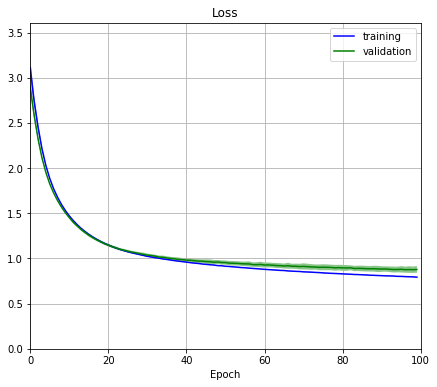

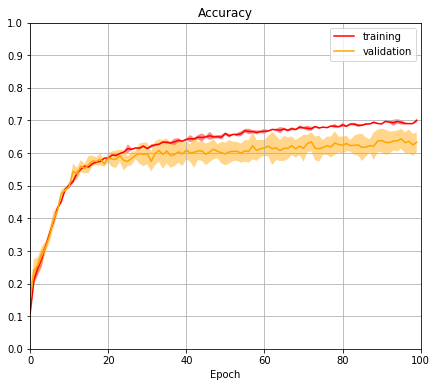

precision and recall
p= 0
r= 0
p_avg= 0.6298414728546308
r_avg= 0.6357142857142857
1 	 0.64 	 0.57
2 	 0.53 	 0.75
3 	 0.31 	 0.11
4 	 0.83 	 0.86
5 	 0.73 	 0.79
6 	 0.82 	 0.71
7 	 0.36 	 0.46
8 	 0.54 	 0.36
9 	 1.0 	 1.0
10 	 0.48 	 0.71
11 	 0.28 	 0.36
12 	 0.87 	 0.93
13 	 0.78 	 0.82
14 	 0.12 	 0.11
15 	 0.25 	 0.29
16 	 1.0 	 0.93
17 	 0.81 	 0.75
18 	 0.52 	 0.64
19 	 0.86 	 0.86
20 	 0.58 	 0.64
21 	 0.79 	 0.79
22 	 0.47 	 0.39
23 	 0.53 	 0.43
24 	 0.96 	 0.93
25 	 0.7 	 0.71


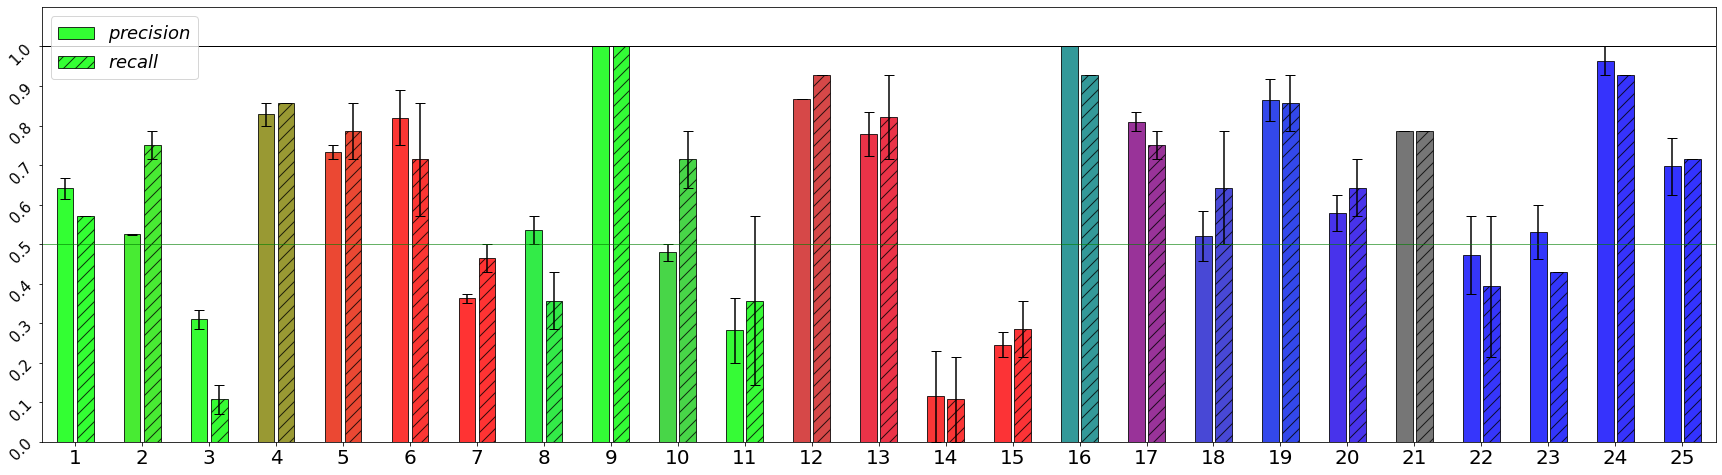

In [11]:
plot_data(ker_results[0],ker_results[1],ker_results[2],ker_results[3],ker_results[4],ker_results[5])